# N225 Japan Index trading


### Import dependecies 

In [1]:
import gym
import gym_anytrading
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum

import tensorboard

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import A2C
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

import pandas as pd
from matplotlib import pyplot as plt
from typing import Callable, Dict, List, Optional, Tuple, Type, Union

import torch as th
from torch import nn

from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

from finta import TA
from gym_anytrading.envs import StocksEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

import os

import torch

### Data processing

In [2]:
df = pd.read_csv('data/N225.csv')

In [3]:
df = pd.read_csv('data/SPX500.csv')

In [3]:
df.dropna(inplace=True)

In [4]:
df.dropna(inplace=True)
df['RSI'] = TA.RSI(df)
df['SMA'] = TA.SMA(df,14)
df['ATR'] = TA.ATR(df)
df.dropna(inplace=True)

In [5]:
# Load your financial data into a DataFrame (replace with your own data)
# df = pd.read_csv('your_data.csv')

# Calculate the top 20 technical analysis metrics
sma = TA.SMA(df,20)
ema = TA.EMA(df,20)
rsi = TA.RSI(df,14)
macd = TA.MACD(df)
# upper, mid, lower = TA.BBANDS(df)
atr = TA.ATR(df)
stoch = TA.STOCH(df)
# cci = TA.CCI(df)
roc = TA.ROC(df)
obv = TA.OBV(df)
adx = TA.ADX(df)
# cmf = TA.CMF(df)
uo = TA.UO(df)
wr = TA.WILLIAMS(df)
# sar = TA.PSAR(df)
# upper, mid, lower = TA.MAE(df['Close'], period=20, percent=0.1)
# conversion_line, base_line, leading_span_A, leading_span_B, lagging_span = TA.ICHIMOKU(df['High'], df['Low'])
adx = TA.ADX(df)
# mfi = TA.MFI(df)
# co = TA.CHO(df)
# Combine all the metrics into a single DataFrame
all_metrics_df= pd.DataFrame({
    'SMA': sma,
    'EMA': ema,
    'RSI': rsi,
    'MACD': macd.MACD,
    'MACD_SIGNAL' : macd.SIGNAL,
    # # 'BBANDS_Upper': upper,
    # # 'BBANDS_Mid': mid,
    # # 'BBANDS_Lower': lower,
    'ATR': atr,
    'Stochastic': stoch,
    # 'CCI': cci,
    'ROC': roc,
    'OBV': obv,
    'ADX': adx,
    # 'UO': uo,
    'Williams %R': wr,
    # 'MFI': mfi
})

# Display the DataFrame with all the calculated metrics
# print(all_metrics_df.tail())
df = df.merge(all_metrics_df, right_index=True, left_index=True)

In [6]:
df.dropna(inplace=True)

## Creating custom LSTM model for trading

I create this custom model, becouse I assume, LSTM will work better then normal Neural net. 

 Architecture of this model may change, depending on the final results

In [7]:
class customLSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm=nn.LSTM(input_size,hidden_size,num_layers=3,bidirectional= True)#,batch_first=True)
        self.fully_connected=nn.Sequential(
            nn.Linear(hidden_size*2,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024,2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            # nn.Dropout(0.2),
            # nn.Linear(2048,512),
            # nn.BatchNorm1d(512),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            # nn.Linear(2048,1024),
            # nn.BatchNorm1d(1024),
            # nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512,output_size),
            nn.ReLU()
        )
    def forward(self,x):
        batch_size=x.shape[0]
        h0=torch.zeros(3*2,self.hidden_size).cuda()
        c0=torch.zeros(3*2,self.hidden_size).cuda()

        lstm_output, cels = self.lstm(x,(h0,c0))
        # print(cels[1].shape)
        flatten_output=torch.flatten(lstm_output,start_dim=1)
        
        output=self.fully_connected(flatten_output)
        
        return output



In [9]:
# from stable_baselines3 import PPO
# from stable_baselines3.common.policies import ActorCriticPolicy


class CustomNetwork(nn.Module):
    """
    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 128,
        last_layer_dim_vf: int = 128,
    ):
        super(CustomNetwork, self).__init__()

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        # Policy network
        # self.policy_net = nn.Sequential(
        #     nn.Linear(feature_dim, last_layer_dim_pi), nn.ReLU()
        # )
        
        self.policy_net = customLSTM(feature_dim,512,last_layer_dim_pi)
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, 512), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(512,256), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(256,256), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(256,128), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(128,last_layer_dim_vf), 
            nn.ReLU()
        )

    def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        return self.policy_net(features), self.value_net(features)

    def forward_actor(self, features: th.Tensor) -> th.Tensor:
        return self.policy_net(features)

    def forward_critic(self, features: th.Tensor) -> th.Tensor:
        return self.value_net(features)


class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        lr_schedule: Callable[[float], float],
        net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        *args,
        **kwargs,
    ):

        super(CustomActorCriticPolicy, self).__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
        # Disable orthogonal initialization
        self.ortho_init = False

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)



## Creating the enviorment and declaring PPO model with custom LSTM net

In [10]:
from enviorment import StocksEnv

In [11]:
env = StocksEnv(df=df,window_size = 14, frame_bound=(2000,5000), bid_percent=0.003)

In [23]:
obs = env.reset()

In [24]:
obs.shape

(14, 19)

In [13]:
save_path = os.path.join('Training', 'Saved_models_N225')
log_path = os.path.join('Training','Logs')
eval_callback = EvalCallback(env, 
                             eval_freq = 10000, 
                             verbose = 1, 
                             best_model_save_path = save_path)

In [14]:
from enviorment import StocksEnv
env = StocksEnv(df=df,window_size = 14, frame_bound=(2000,5000), bid_percent=0.002)
save_path = os.path.join('Training', 'Saved_models_N225')
log_path = os.path.join('Training','Logs')
eval_callback = EvalCallback(env, 
                             eval_freq = 10000, 
                             verbose = 1, 
                             best_model_save_path = save_path)
model = PPO(CustomActorCriticPolicy, env, verbose=1,tensorboard_log = log_path, learning_rate = 0.0003)
%time model.learn(50000,callback = eval_callback)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to Training\Logs\PPO_1
-----------------------------
| time/              |      |
|    fps             | 177  |
|    iterations      | 1    |
|    time_elapsed    | 11   |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 3e+03        |
|    ep_rew_mean          | -4.87e+04    |
| time/                   |              |
|    fps                  | 95           |
|    iterations           | 2            |
|    time_elapsed         | 43           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0030221853 |
|    clip_fraction        | 0.0138       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | -0.000161    |
|    learning_rate 

C:\Users\aczer\AppData\Local\Programs\Python\Python39\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=0.00 +/- 0.00
Episode length: 2999.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 3e+03       |
|    mean_reward          | 0           |
| time/                   |             |
|    total_timesteps      | 10000       |
| train/                  |             |
|    approx_kl            | 0.012800225 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.07       |
|    explained_variance   | 0.323       |
|    learning_rate        | 0.0003      |
|    loss                 | 2.76e+04    |
|    n_updates            | 40          |
|    policy_gradient_loss | 0.0112      |
|    value_loss           | 5.76e+04    |
-----------------------------------------
New best mean reward!
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 3e+03     |
|    ep_rew_mean     | -3.54e

In [16]:
torch.cuda.is_available()

True

info {'total_reward': -6618.111289465134, 'total_profit': 0.46811054974585053, 'position': 2}


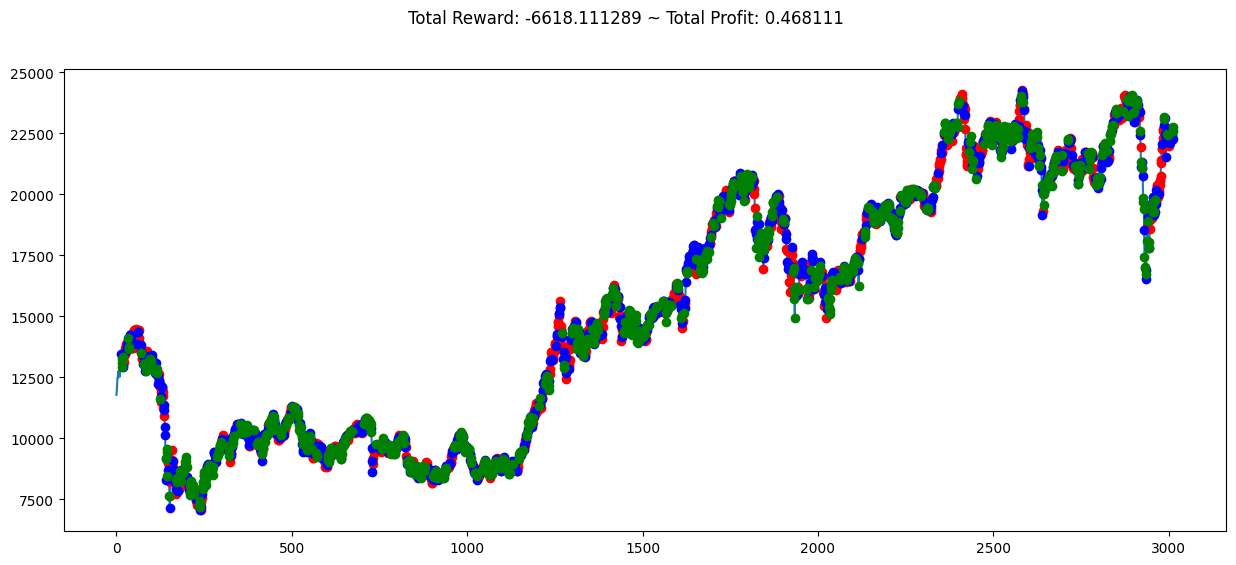

In [17]:
env = StocksEnv(df = df, frame_bound=(2000,5000), window_size = 14,bid_percent=0.00015)
obs = env.reset()
while True:
    # obs = obs[np.newaxis, ...]
    # print(obs.shape)
    action, _states = model.predict(obs)
    obs,rewards,done,info = env.step(action)
    if done:
        print("info",info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

info {'total_reward': 1852.3198687823424, 'total_profit': 1.0263884869312512, 'position': 1}


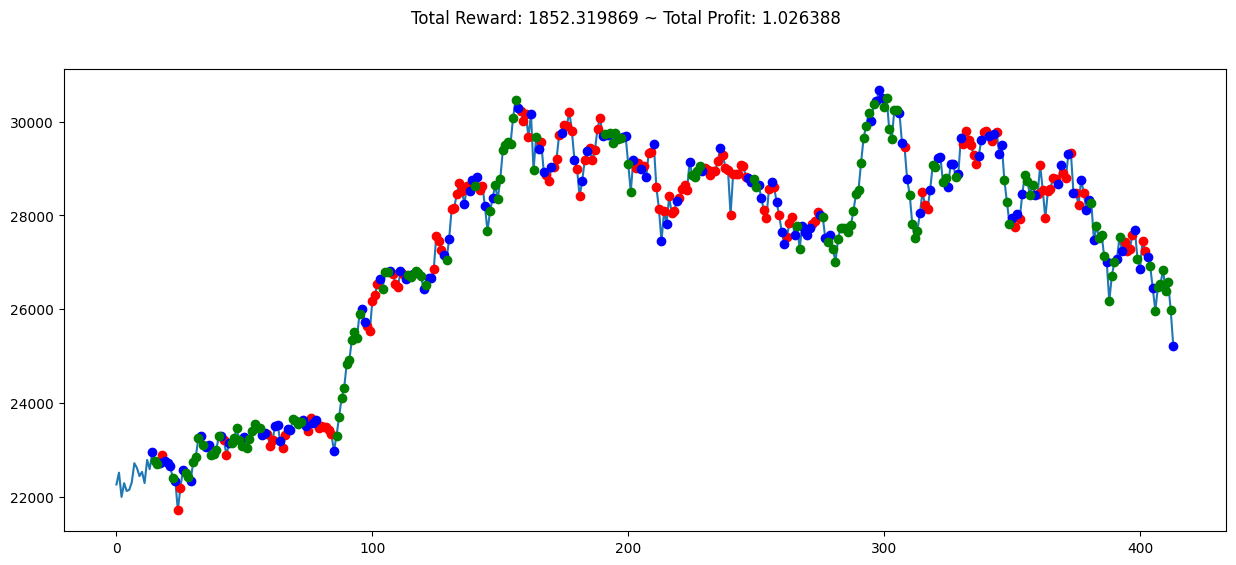

In [18]:
env = StocksEnv(df = df, frame_bound=(5000,5400), window_size = 14,bid_percent=0.00015)
obs = env.reset()
while True:
    # obs = obs[np.newaxis, ...]
    # print(obs.shape)
    action, _states = model.predict(obs)
    obs,rewards,done,info = env.step(action)
    if done:
        print("info",info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [ ]:
df.iloc[5400].Close/df.iloc[5000].Close

### Bulding Transformer model

In [6]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor

class PositionalEncoder(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what 
    the positional encoding layer does and why it is needed:
    
    "Since our model contains no recurrence and no convolution, in order for the 
    model to make use of the order of the sequence, we must inject some 
    information about the relative or absolute position of the tokens in the 
    sequence." (Vaswani et al, 2017)

    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=14, 
        d_model: int=512,
        batch_first: bool=False
        ):

        """
        Parameters:

            dropout: the dropout rate

            max_seq_len: the maximum length of the input sequences

            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        self.x_dim = 1 if batch_first else 0

        # copy pasted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_seq_len, 1, d_model)
        
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """

        x = x + self.pe[:x.size(self.x_dim)]

        return self.dropout(x)

In [8]:
def generate_square_subsequent_mask(dim1: int, dim2: int) -> Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Source:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    Args:

        dim1: int, for both src and tgt masking, this must be target sequence
              length

        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 


    Return:

        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)

# Input length
enc_seq_len = 100

# Output length
output_sequence_length = 58

# Make src mask for decoder with size:
tgt_mask = generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=output_sequence_length
   )

src_mask = generate_square_subsequent_mask(
    dim1=output_sequence_length,
    dim2=enc_seq_len
    )

In [65]:
import torch.nn as nn
from torch import nn, Tensor
# import positional_encoder as pe
import torch.nn.functional as F
import torch
from typing import Tuple

class TimeSeriesTransformer(nn.Module):
    """
    This class implements a transformer model that can be used for times series
    forecasting. This time series transformer model is based on the paper by
    Wu et al (2020) [1]. The paper will be referred to as "the paper".

    A detailed description of the code can be found in my article here:

    https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e

    In cases where the paper does not specify what value was used for a specific
    configuration/hyperparameter, this class uses the values from Vaswani et al
    (2017) [2] or from PyTorch source code.

    Unlike the paper, this class assumes that input layers, positional encoding
    layers and linear mapping layers are separate from the encoder and decoder,
    i.e. the encoder and decoder only do what is depicted as their sub-layers
    in the paper. For practical purposes, this assumption does not make a
    difference - it merely means that the linear and positional encoding layers
    are implemented inside the present class and not inside the
    Encoder() and Decoder() classes.

    [1] Wu, N., Green, B., Ben, X., O'banion, S. (2020).
    'Deep Transformer Models for Time Series Forecasting:
    The Influenza Prevalence Case'.
    arXiv:2001.08317 [cs, stat] [Preprint].
    Available at: http://arxiv.org/abs/2001.08317 (Accessed: 9 March 2022).

    [2] Vaswani, A. et al. (2017)
    'Attention Is All You Need'.
    arXiv:1706.03762 [cs] [Preprint].
    Available at: http://arxiv.org/abs/1706.03762 (Accessed: 9 March 2022).

    """

    def __init__(self,
                 input_size: int,
                 dec_seq_len: int,
                 batch_first: bool,
                 out_seq_len: int = 58,
                 dim_val: int = 512,
                 n_encoder_layers: int = 4,
                 n_decoder_layers: int = 4,
                 n_heads: int = 8,
                 dropout_encoder: float = 0.2,
                 dropout_decoder: float = 0.2,
                 dropout_pos_enc: float = 0.1,
                 dim_feedforward_encoder: int = 2048,
                 dim_feedforward_decoder: int = 2048,
                 num_predicted_features: int = 1
                 ):
        """
        Args:

            input_size: int, number of input variables. 1 if univariate.

            dec_seq_len: int, the length of the input sequence fed to the decoder

            dim_val: int, aka d_model. All sub-layers in the model produce
                     outputs of dimension dim_val

            n_encoder_layers: int, number of stacked encoder layers in the encoder

            n_decoder_layers: int, number of stacked encoder layers in the decoder

            n_heads: int, the number of attention heads (aka parallel attention layers)

            dropout_encoder: float, the dropout rate of the encoder

            dropout_decoder: float, the dropout rate of the decoder

            dropout_pos_enc: float, the dropout rate of the positional encoder

            dim_feedforward_encoder: int, number of neurons in the linear layer
                                     of the encoder

            dim_feedforward_decoder: int, number of neurons in the linear layer
                                     of the decoder

            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 because we're
                                    only forecasting FCR-N prices in DK2, but in
                                    we wanted to also predict FCR-D with the same
                                    model, num_predicted_features should be 2.
        """

        super().__init__()

        self.dec_seq_len = dec_seq_len

        # print("input_size is: {}".format(input_size))
        # print("dim_val is: {}".format(dim_val))

        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size,
            out_features=dim_val
        )

        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val
        )

        self.linear_mapping = nn.Linear(
            in_features=dim_val,
            out_features=num_predicted_features
        )

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc
        )

        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
        )

        # Stack the encoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerEncoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers,
            norm=None
        )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
        )

        # Stack the decoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerDecoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers,
            norm=None
        )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor = None,
                tgt_mask: Tensor = None) -> Tensor:
        """
        Returns a tensor of shape:

        [target_sequence_length, batch_size, num_predicted_features]

        Args:

            src: the encoder's output sequence. Shape: (S,E) for unbatched input,
                 (S, N, E) if batch_first=False or (N, S, E) if
                 batch_first=True, where S is the source sequence length,
                 N is the batch size, and E is the number of features (1 if univariate)

            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input,
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if
                 batch_first=True, where T is the target sequence length,
                 N is the batch size, and E is the number of features (1 if univariate)

            src_mask: the mask for the src sequence to prevent the model from
                      using data points from the target sequence

            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence


        """

        # print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        # print("From model.forward(): tgt size = {}".format(tgt.size()))

        # Pass throguh the input layer right before the encoder
        src = src.to(torch.float32)
        src = self.encoder_input_layer(src)  # src shape: [batch_size, src length, dim_val] regardless of number of input features
        # print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(
            src)  # src shape: [batch_size, src length, dim_val] regardless of number of input features
        # print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder
        # Masking is only needed in the encoder if input sequences are padded
        # which they are not in this time series use case, because all my
        # input sequences are naturally of the same length.
        # (https://github.com/huggingface/transformers/issues/4083)
        src = self.encoder(  # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
        )
        # print("From model.forward(): Size of src after encoder: {}".format(src.size()))

        # Pass decoder input through decoder input layer
        tgt = tgt.to(torch.float32)
        decoder_output = self.decoder_input_layer(
            tgt)  # src shape: [target sequence length, batch_size, dim_val] regardless of number of input features
        # print("From model.forward(): Size of decoder_output after linear decoder layer: {}".format(decoder_output.size()))

        # if src_mask is not None:
        #     print("From model.forward(): Size of src_mask: {}".format(src_mask.size()))
        # if tgt_mask is not None:
        #     print("From model.forward(): Size of tgt_mask: {}".format(tgt_mask.size()))

        # Pass throguh decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
        )

        # print("From model.forward(): decoder_output shape after decoder: {}".format(decoder_output.shape))

        # Pass through linear mapping
        decoder_output = self.linear_mapping(decoder_output)  # shape [batch_size, target seq len]
        # print("From model.forward(): decoder_output size after linear_mapping = {}".format(decoder_output.size()))

        return decoder_output

    def get_src_trg(
            self,
            sequence: torch.Tensor,
            enc_seq_len: int,
            target_seq_len: int
    ) -> Tuple[torch.tensor, torch.tensor]:
        """
        Generate the src (encoder input), trg (decoder input) and trg_y (the target)
        sequences from a sequence.
        Args:
            sequence: tensor, a 1D tensor of length n where
                    n = encoder input length + target sequence length
            enc_seq_len: int, the desired length of the input to the transformer encoder
            target_seq_len: int, the desired length of the target sequence (the
                            one against which the model output is compared)
        Return:
            src: tensor, 1D, used as input to the transformer model
            trg: tensor, 1D, used as input to the transformer model
            trg_y: tensor, 1D, the target sequence against which the model output
                is compared when computing loss.

        """
        # print("Called dataset.TransformerDataset.get_src_trg")
        assert len(
            sequence) == enc_seq_len + target_seq_len, "Sequence length does not equal (input length + target length)"

        # print("From data.TransformerDataset.get_src_trg: sequence shape: {}".format(sequence.shape))

        # encoder input
        src = sequence[:enc_seq_len]

        # decoder input. As per the paper, it must have the same dimension as the
        # target sequence, and it must contain the last value of src, and all
        # values of trg_y except the last (i.e. it must be shifted right by 1)
        trg = sequence[enc_seq_len - 1:len(sequence)]

        # print("From data.TransformerDataset.get_src_trg: trg shape before slice: {}".format(trg.shape))

        trg = trg[:, 0]

        # print("From data.TransformerDataset.get_src_trg: trg shape after slice: {}".format(trg.shape))

        if len(trg.shape) == 1:
            trg = trg.unsqueeze(-1)

            # print("From data.TransformerDataset.get_src_trg: trg shape after unsqueeze: {}".format(trg.shape))

        assert len(trg) == target_seq_len, "Length of trg does not match target sequence length"

        # The target sequence against which the model output will be compared to compute loss
        # trg_y = sequence[-target_seq_len:]

        # print("From data.TransformerDataset.get_src_trg: trg_y shape before slice: {}".format(trg_y.shape))

        # We only want trg_y to consist of the target variable not any potential exogenous variables
        # trg_y = trg_y[:, 0]

        # print("From data.TransformerDataset.get_src_trg: trg_y shape after slice: {}".format(trg_y.shape))

        assert len(trg_y) == target_seq_len, "Length of trg_y does not match target sequence length"

        return src, trg  # change size from [batch_size, target_seq_len, num_features] to [batch_size, target_seq_len]


In [76]:
class TransformerModel(nn.Module):
    def __init__(dim_val,
                 input_size, 
    dec_seq_len,
    n_heads,
    # max_seq_len=max_seq_len,
    out_seq_len, 
    n_decoder_layers = 4,
    n_encoder_layers = 4,
                 #     input_size: int,
                 # dec_seq_len: int,
                 # batch_first: bool,
                 # out_seq_len: int = 58,
                 # dim_val: int = 512,
    batch_first = False):
        
        super(TransformerModel,self).__init__()

        self.transformer = TimeSeriesTransformer(input_size=input_size,                                     
            dec_seq_len=dec_seq_len,
            batch_first = False,
            # max_seq_len=max_seq_len,
            out_seq_len=output_sequence_length, 
            dim_val=dim_val,
            n_decoder_layers=n_decoder_layers,
            n_encoder_layers=n_encoder_layers,
            n_heads=n_heads)
        self.fully_connected=nn.Sequential(
            nn.Linear(out_seq_len,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # nn.Dropout(0.2),
            nn.Linear(128,248),
            nn.BatchNorm1d(248),
            nn.ReLU(),
            nn.Linear(248,output_size),
            nn.ReLU()
        )
    def forward(self,x):
        src,trg = transformer.get_src_trg(x,30,14)
        transformer_output = transformer(src,trg)
        output = fully_connected(transformer_output.flatten())
    

In [77]:
class TransformerNetwork(nn.Module):
    """
    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 128,
        last_layer_dim_vf: int = 128,
    ):
        super(TransformerNetwork, self).__init__()

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        # Policy network
        # self.policy_net = nn.Sequential(
        #     nn.Linear(feature_dim, last_layer_dim_pi), nn.ReLU()
        # )
        dim_val = 512 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
        n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
        n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
        n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
        input_size = 19 # The number of input variables. 1 if univariate forecasting.
        dec_seq_len = 14 # length of input given to decoder. Can have any integer value.
        enc_seq_len = 30 # length of input given to encoder. Can have any integer value.
        output_sequence_length = 5 # Length of the target sequence, i.e. how many time steps should your forecast cover
        max_seq_len = 44 # What's the longest sequence the model will encounter? Used to make the positional encoder

        
        self.policy_net = TransformerModel(input_size=input_size,
                      
            dec_seq_len=dec_seq_len,
            # batch_first = False,
            # max_seq_len=max_seq_len,
            out_seq_len=output_sequence_length, 
            dim_val=dim_val,
            n_decoder_layers=n_decoder_layers,
            n_encoder_layers=n_encoder_layers,
            n_heads=n_heads)
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, 512), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(512,256), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(256,256), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(256,128), 
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(128,last_layer_dim_vf), 
            nn.ReLU()
        )

    def forward(self, features: th.Tensor) -> Tuple[th.Tensor, th.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        return self.policy_net(features), self.value_net(features)

    def forward_actor(self, features: th.Tensor) -> th.Tensor:
        return self.policy_net(features)

    def forward_critic(self, features: th.Tensor) -> th.Tensor:
        return self.value_net(features)


class TransformerActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        lr_schedule: Callable[[float], float],
        net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        *args,
        **kwargs,
    ):

        super(TransformerActorCriticPolicy, self).__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
        # Disable orthogonal initialization
        self.ortho_init = False

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = TransformerNetwork(self.features_dim)

In [75]:
dim_val = 512 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 19 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 14 # length of input given to decoder. Can have any integer value.
enc_seq_len = 30 # length of input given to encoder. Can have any integer value.
output_sequence_length = 5 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = 44 # What's the longest sequence the model will encounter? Used to make the positional encoder



# trans = TransformerNetwork(19)
trans = TransformerModel(


TypeError: __init__() got multiple values for argument 'dim_val'

In [68]:
# ## Model parameters
# dim_val = 512 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
# n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
# n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
# n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
# input_size = 1 # The number of input variables. 1 if univariate forecasting.
# dec_seq_len = 92 # length of input given to decoder. Can have any integer value.
# enc_seq_len = 153 # length of input given to encoder. Can have any integer value.
# output_sequence_length = 58 # Length of the target sequence, i.e. how many time steps should your forecast cover
# max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder

# model = TimeSeriesTransformer(
#     dim_val=dim_val,
#     input_size=input_size, 
#     dec_seq_len=dec_seq_len,
#     batch_first = False,
#     # max_seq_len=max_seq_len,
#     out_seq_len=output_sequence_length, 
#     n_decoder_layers=n_decoder_layers,
#     n_encoder_layers=n_encoder_layers,
#     n_heads=n_heads)

In [78]:
from enviorment import StocksEnv
env = StocksEnv(df=df,window_size = 44, frame_bound=(100,2500), bid_percent=0.002)

In [79]:
save_path = os.path.join('Training', 'Saved_models_N225')
log_path = os.path.join('Training','Logs')
eval_callback = EvalCallback(env, 
                             eval_freq = 10000, 
                             verbose = 1, 
                             best_model_save_path = save_path)

In [80]:
trans_ppo = PPO(TransformerActorCriticPolicy, env, verbose=1,tensorboard_log = log_path, learning_rate = 0.0003)
%time model.learn(50000,callback = eval_callback)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


TypeError: __init__() got multiple values for argument 'dim_val'

### Bactesting with a trading tool


In [2]:
import backtesting

C:\Users\aczer\AppData\Local\Programs\Python\Python39\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
from backtesting import Backtest, Strategy

In [4]:
class MLStrategy(Strategy):
    def __init__(self, model, df):
        self.model = model
        price = price.Close
        data = data
    def next(self):
        ### give the AI model normalized data so that 
        ### it can perform a predicion that will give a sell or buy order

IndentationError: expected an indented block (949243979.py, line 8)